# 0. Attaching libraries

In [1]:
import os
import sqlite3
import pandas as pd
import sys
#from ydata_profiling import ProfileReport # for profiling
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
sns.set_style("whitegrid")       # optional aesthetics
%matplotlib inline 

In [2]:
# Pre-processing & modelling
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans

# Cluster diagnostics
from sklearn.metrics import silhouette_score

In [3]:
from dateutil.relativedelta import relativedelta
import builtins

In [4]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn")

import matplotlib.patches as mpatches


In [5]:
from sklearn.decomposition import PCA

# 1. Reading the core Dataset from the golden source

In [6]:
csv_file  = "https://raw.githubusercontent.com/mithridata-com/NOVAIMS_BDMwDS_PROJECT/refs/heads/main/00%20Data/Dataset.csv?token=GHSAT0AAAAAADEUY5L7N2QTI43CBPMTAV5O2CIUAMQ"

excel_path  = (r"C:\Users\dimet\Documents\GitHub\NOVAIMS_BDMwDS_PROJECT\02 Output\02 TB Conversion Analytics.xlsx")

In [7]:
# ── Load the CSV into a DataFrame ──────────────────────────────────────────
df = pd.read_csv(csv_file, low_memory=False)

In [8]:
# Quick sanity check (optional)
print(df.shape)       # prints (rows, columns)

(9373, 78)


In [9]:
df.columns

Index(['affinity_name', 'status_report', 'offer_number', 'policy_number',
       'zipcode_link', 'zip4', 'birth_date', 'brand', 'date_offer',
       'date_request', 'policy_start_date', 'premium', 'buildyear_car',
       'buildmonth_car', 'wa', 'wa_bep_ca', 'wa_ca', 'updated_on',
       'policy_continuation_date', 'policy_start_date_pol',
       'policy_lastchange_date', 'premium_wa', 'premium_other',
       'zipcode_link_pol', 'zip4_pol', 'place_residence', 'birth_date_pol',
       'gender', 'private_commercial', 'bonus_malus_percent', 'other_cover',
       'premium_other_incl_discount', 'worth_car', 'brand_pol',
       'builddate_car', 'weight_car', 'mileage_car', 'power_car', 'fuel_car',
       'chassis', 'drive', 'turbo', 'transmission', 'zip4_reg', 'PROVINCE',
       'URB', 'INCOME', 'SOCCL_A', 'SOCCL_B1', 'SOCCL_B2', 'SOCCL_C',
       'SOCCL_D', 'EDU_HIGH', 'EDU_MID', 'EDU_LOW', 'DINK', 'OWN_HOUSE',
       'AVG_HOUSE', 'RENT_PRICE', 'STAGE_OF_LIFE', 'SINGLE', 'FAM',
       'FAM_W

## NEW COLUMNS

In [10]:
df["customer_id"] = df[["zipcode_link", "zip4", "place_residence","birth_date", "gender"]].astype(str).agg("-".join, axis=1)

In [11]:
df['premium_total'] = df['premium_wa'].fillna(0) + df['premium_other'].fillna(0)

In [12]:
df['premium_discount'] = df['premium_other'].fillna(0) - df['premium_other_incl_discount'].fillna(0)

In [13]:
# 1. Build boolean conditions based on == "Y"
conditions = [
    df['wa'] == 'Y',
    df['wa_bep_ca'] == 'Y',
    df['wa_ca'] == 'Y'
]

# 2. Corresponding labels
choices = ['1. Only liability insurance', '2. Liability + limited casco', '3. Liability + full casco']

# 3. Create the new column, defaulting to NaN if none of the three has "Y"
df['coverage_type'] = np.select(conditions, choices, default="")

In [14]:
# ── 1. External “today” reference ───────────────────────────────────────────
current_date = pd.to_datetime("2019-11-01")    # ← use any value you like
fancy_date = current_date.strftime("%B %d %Y")

In [15]:
# ── 2. Parse birth_date & compute age ───────────────────────────────────────
# 2-a. Ensure birth_date is a datetime column
df["birth_date"] = pd.to_datetime(df["birth_date"], errors="coerce")

# 2-b. Convert to integer years using dateutil.relativedelta for accuracy
df["age"] = df["birth_date"].apply(
    lambda bd: relativedelta(current_date, bd).years if pd.notnull(bd) else pd.NA
)
# ── 1. Ensure age is numeric ────────────────────────────────────────────────
# (errors='coerce' converts any bad strings to NaN so they drop out later)
df["age"] = pd.to_numeric(df["age"], errors="coerce")

# ── 2. Create age bands ─────────────────────────────────────────────────────
age_bins   = [0, 25, 35, 45, 55, 65, 120]               # tweak if needed
age_labels = ["<25", "25–34", "35–44", "45–54", "55–64", "65+"]

In [16]:
df["age_band"] = pd.cut(df["age"],
                           bins=age_bins,
                           labels=age_labels,
                           right=False)

In [17]:
df["urb_norm"] = (
    df["URB"]
      .astype(str)
      .str.strip()
      .str[0]                    # first letter
      .str.upper()
      .replace({"1": "1-VeryHigh", "2": "2-High", "3": "3-Mid-to-High", "4": "4-Mid", "5": "5-Mid-to-Low", "6": "6-Low","7": "7-VeryLow", "0": "Unknown", "N" : "Unknown"})
)

In [18]:
month_map = {
    "January":   "01",
    "February":  "02",
    "March":     "03",
    "April":     "04",
    "May":       "05",
    "June":      "06",
    "July":      "07",
    "August":    "08",
    "September": "09",
    "October":   "10",
    "November":  "11",
    "December":  "12"
}

df["buildmonth_num"] = df["buildmonth_car"].map(month_map)

In [19]:
# 2. Combine year + month + “01” (first of month) into a YYYY-MM-DD string and convert to datetime:
df["build_date"] = pd.to_datetime(
    df["buildyear_car"].astype(str).str[:4] + "-" + 
    df["buildmonth_num"] + "-01"
)

# Now 'build_date' holds a Timestamp for the first day of that month/year.
print(df[["buildyear_car", "buildmonth_car", "build_date"]].head())

   buildyear_car buildmonth_car build_date
0         2016.0           June 2016-06-01
1         2015.0           June 2015-06-01
2         2016.0          April 2016-04-01
3         2009.0           June 2009-06-01
4         2003.0        January 2003-01-01


In [20]:
# Calculate car_age
df['car_age'] = current_date.year - df['build_date'].dt.year - (
    (current_date.month < df['build_date'].dt.month) |
    ((current_date.month == df['build_date'].dt.month) & (current_date.day < df['build_date'].dt.day))
).astype(int)

In [21]:
# 1) Make sure `policy_start_date` is a datetime:
df['policy_start_date'] = pd.to_datetime(
    df['policy_start_date'],
    errors='coerce'
)

In [22]:
# Define age bins and labels
bins = [0, 3, 7, 11, 100]
labels = ['0-3', '4-7', '8-11', '12+']

# Create normalized age categories
df['car_age_norm'] = pd.cut(df['car_age'], bins=bins, labels=labels, include_lowest=True).cat.add_categories('Unknown').fillna("Unknown")


In [23]:
df

affinity_name           status_report  offer_number  policy_number  \
0           Insuro        Requestwithdrawn          1000        10000.0   
1            other  Tailoredofferwithdrawn          1001            NaN   
2            other       Incompleterequest          1002            NaN   
3            other           Policycreated          1003        10002.0   
4            other           Policycreated          1004        10003.0   
...            ...                     ...           ...            ...   
9368         other         Requestaccepted          9439        11946.0   
9369         other         Waitforapproval          9440        11947.0   
9370        Insuro  Tailoredofferrequested          9441            NaN   
9371           T&B     Calculatenewpremium          9442            NaN   
9372           T&B       Incompleterequest          9443            NaN   

      zipcode_link  zip4 birth_date       brand  date_offer date_request  ...  \
0            10000  2132 1985-01-01     HYUNDAI  2018-10-11   2018-10-11  ...   
1            10001  6027 1987-04-01        AUDI  2018-10-11          NaN  ...   
2            10002  3824 1972-11-01  VOLKSWAGEN  2018-10-11          NaN  ...   
3            10003  6921 1983-08-01       MAZDA  2018-10-11   2018-10-11  ...   
4            10004  8266 1990-04-01       VOLVO  2018-10-12   2018-10-12  ...   
...            ...   ...        ...         ...         ...          ...  ...   
9368         15568  1161 1960-09-01  VOLKSWAGEN  2020-03-08   2020-03-08  ...   
9369         15582  5015 1953-04-01      NISSAN  2020-03-08   2020-03-08  ...   
9370         10332  3078 1976-04-01      TOYOTA  2020-03-08          NaN  ...   
9371         12968  1965 1951-07-01      TOYOTA  2020-03-08          NaN  ...   
9372         15526  1165 1964-01-01       VOLVO  2020-03-08          NaN  ...   

     premium_total  premium_discount                 coverage_type   age  \
0              0.0               0.0   1. Only liability insurance  34.0   
1              0.0               0.0                                32.0   
2              0.0               0.0     3. Liability + full casco  47.0   
3              0.0               0.0  2. Liability + limited casco  36.0   
4              0.0               0.0   1. Only liability insurance  29.0   
...            ...               ...                           ...   ...   
9368           0.0               0.0     3. Liability + full casco  59.0   
9369           0.0               0.0     3. Liability + full casco  66.0   
9370           0.0               0.0  2. Liability + limited casco  43.0   
9371           0.0               0.0  2. Liability + limited casco  68.0   
9372           0.0               0.0     3. Liability + full casco  55.0   

     age_band       urb_norm buildmonth_num build_date car_age car_age_norm  
0       25–34  3-Mid-to-High             06 2016-06-01     3.0          0-3  
1       25–34      7-VeryLow             06 2015-06-01     4.0          4-7  
2       45–54         2-High             04 2016-04-01     3.0          0-3  
3       35–44          4-Mid             06 2009-06-01    10.0         8-11  
4       25–34          4-Mid             01 2003-01-01    16.0          12+  
...       ...            ...            ...        ...     ...          ...  
9368    55–64          6-Low             12 2011-12-01     7.0          4-7  
9369      65+         2-High             02 2017-02-01     2.0          0-3  
9370    35–44     1-VeryHigh             01 2004-01-01    15.0          12+  
9371      65+          4-Mid             09 2004-09-01    15.0          12+  
9372    55–64      7-VeryLow             06 2015-06-01     4.0          4-7  

[9373 rows x 89 columns]

In [24]:
# list of cols to convert
num_cols = ['worth_car', 'weight_car', 'mileage_car', 'power_car']

# coerce to numeric, invalid parsing becomes NaN
for c in num_cols:
    df[c] = pd.to_numeric(df[c], errors='coerce')

# IMPUTATION

In [25]:
num_cols = [
    'worth_car',
    'weight_car',
    'mileage_car',
    'power_car'
]

cat_cols = [
    'chassis',
    'fuel_car',
    'drive',
    'turbo',
    'transmission'
]


In [26]:
# for each numeric column, fill NAs with the mean _within_ its brand
df[num_cols] = (
    df
    .groupby('brand')[num_cols]
    .transform(lambda col:
        col.fillna(col.mean())    # group-mean imputation
    )
)

In [27]:
def fill_with_mode(series):
    # find the most common value
    modes = series.dropna().mode()
    if len(modes) > 0:
        return series.fillna(modes.iloc[0])
    else:
        return series

df[cat_cols] = (
    df
    .groupby('brand')[cat_cols]
    .transform(fill_with_mode)
)

In [28]:
print(df[num_cols + cat_cols].isna().sum())

worth_car       302
weight_car      302
mileage_car     302
power_car       302
chassis         302
fuel_car        302
drive           302
turbo           302
transmission    302
dtype: int64


In [29]:
mode_income = (
    df
    .groupby('zip4')['INCOME']
    .agg(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan)
    .rename('mode_income')
)

# 2. Merge the mode back into the original DataFrame
df = df.merge(mode_income, left_on='zip4', right_index=True)

# 3. Impute missing INCOME values using the mode for that zip4
df['INCOME_filled'] = df['INCOME'].fillna(df['mode_income'])

# 4. (Optional) Drop the helper column if you no longer need it
df.drop(columns=['mode_income'], inplace=True)

In [30]:
# 2. Second imputation: For any remaining NaNs in INCOME, use PROVINCE-level mode
#    - Compute mode income per PROVINCE based on the “INCOME_imputed_zip4” column
mode_income_prov = (
    df
    .groupby('PROVINCE')['INCOME_filled']
    .agg(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan)
    .rename('mode_income_prov')
)

# Merge and fill any remaining NaNs based on province mode
df = df.merge(mode_income_prov, left_on='PROVINCE', right_index=True)
df['INCOME_final'] = df['INCOME_filled'].fillna(df['mode_income_prov'])

# Drop helper columns if desired
df.drop(columns=["INCOME", 'INCOME_filled', 'mode_income_prov'], inplace=True)

## CLUSTERING BY REGION PROFILE

In [31]:
columns_to_keep = ["PROVINCE", 'URB', 'INCOME_final', 'SOCCL_A', 'SOCCL_B1', 'SOCCL_B2', 'SOCCL_C',
                   'SOCCL_D', 'EDU_HIGH', 'EDU_MID', 'EDU_LOW', 'DINK',
                   'OWN_HOUSE', 'AVG_HOUSE',
                   'STAGE_OF_LIFE',# 'SINGLE', 'FAM', 'FAM_WCHILD', 'SINGLES_YOUNG', 'SINGLES_MID', 'SINGLES_OLD', 'FAM_CHILD_Y', 'FAM_CHILD_O', 'FAM_WCHILD_Y', 'FAM_WCHILD_MED','FAM_WCHILD_OLD',
                   'CIT_HOUSEHOLD', 'LOAN', 'SAVINGS', 'SHOP_ONLINE','CAR', # from regional

                   #'age', 'coverage_type','car_age', # from new columns                  
       ]

In [32]:
df_sub = df[(df["affinity_name"]=="T&B")&(df["conv"]==1)][columns_to_keep].copy()

In [33]:
df_sub.shape

(495, 20)

In [34]:
print(df_sub.isna().sum())

PROVINCE         0
URB              0
INCOME_final     0
SOCCL_A          5
SOCCL_B1         5
SOCCL_B2         5
SOCCL_C          5
SOCCL_D          5
EDU_HIGH         5
EDU_MID          5
EDU_LOW          5
DINK             5
OWN_HOUSE        5
AVG_HOUSE        8
STAGE_OF_LIFE    7
CIT_HOUSEHOLD    5
LOAN             5
SAVINGS          5
SHOP_ONLINE      5
CAR              5
dtype: int64


In [35]:
df_sub.dropna(axis=0, how='any', inplace=True)

In [36]:
print(df_sub.isna().sum())

PROVINCE         0
URB              0
INCOME_final     0
SOCCL_A          0
SOCCL_B1         0
SOCCL_B2         0
SOCCL_C          0
SOCCL_D          0
EDU_HIGH         0
EDU_MID          0
EDU_LOW          0
DINK             0
OWN_HOUSE        0
AVG_HOUSE        0
STAGE_OF_LIFE    0
CIT_HOUSEHOLD    0
LOAN             0
SAVINGS          0
SHOP_ONLINE      0
CAR              0
dtype: int64


In [137]:
df_sub[columns_to_keep[1:]].corr()

URB  INCOME_final   SOCCL_A  SOCCL_B1  SOCCL_B2   SOCCL_C  \
URB            1.000000     -0.046869  0.134924  0.212766 -0.051143 -0.196850   
INCOME_final  -0.046869      1.000000 -0.496518 -0.248521  0.168359  0.364002   
SOCCL_A        0.134924     -0.496518  1.000000  0.197711 -0.552387 -0.575639   
SOCCL_B1       0.212766     -0.248521  0.197711  1.000000 -0.101392 -0.568813   
SOCCL_B2      -0.051143      0.168359 -0.552387 -0.101392  1.000000  0.105993   
SOCCL_C       -0.196850      0.364002 -0.575639 -0.568813  0.105993  1.000000   
SOCCL_D       -0.086418      0.458112 -0.505993 -0.531784 -0.067385  0.450855   
EDU_HIGH       0.071603     -0.483206  0.888899  0.210980 -0.474535 -0.550900   
EDU_MID        0.071500     -0.083470 -0.183943  0.548209  0.165523 -0.107287   
EDU_LOW       -0.022535      0.481344 -0.667160 -0.505555  0.342908  0.548368   
DINK           0.224270     -0.393621  0.561171  0.543219 -0.182809 -0.611332   
OWN_HOUSE      0.376427     -0.400090  0.590657  0.522606 -0.271002 -0.588867   
AVG_HOUSE      0.196156     -0.310550  0.701380  0.375707 -0.295190 -0.593316   
STAGE_OF_LIFE  0.310189     -0.168480  0.342648  0.309627 -0.117479 -0.409922   
CIT_HOUSEHOLD  0.106019     -0.117883  0.241783  0.200675  0.002538 -0.319052   
LOAN          -0.357587     -0.060281 -0.174294  0.016050  0.304806  0.083426   
SAVINGS        0.156225     -0.434121  0.587900  0.491950 -0.273651 -0.517108   
SHOP_ONLINE    0.104047     -0.494299  0.601458  0.571421 -0.154918 -0.636901   
CAR            0.449655     -0.330323  0.461151  0.505704 -0.115756 -0.567003   

                SOCCL_D  EDU_HIGH   EDU_MID   EDU_LOW      DINK  OWN_HOUSE  \
URB           -0.086418  0.071603  0.071500 -0.022535  0.224270   0.376427   
INCOME_final   0.458112 -0.483206 -0.083470  0.481344 -0.393621  -0.400090   
SOCCL_A       -0.505993  0.888899 -0.183943 -0.667160  0.561171   0.590657   
SOCCL_B1      -0.531784  0.210980  0.548209 -0.505555  0.543219   0.522606   
SOCCL_B2      -0.067385 -0.474535  0.165523  0.342908 -0.182809  -0.271002   
SOCCL_C        0.450855 -0.550900 -0.107287  0.548368 -0.611332  -0.588867   
SOCCL_D        1.000000 -0.517453 -0.302851  0.664371 -0.556128  -0.525913   
EDU_HIGH      -0.517453  1.000000 -0.236785 -0.694799  0.466010   0.492661   
EDU_MID       -0.302851 -0.236785  1.000000 -0.439402  0.190657   0.183038   
EDU_LOW        0.664371 -0.694799 -0.439402  1.000000 -0.508935  -0.522645   
DINK          -0.556128  0.466010  0.190657 -0.508935  1.000000   0.720795   
OWN_HOUSE     -0.525913  0.492661  0.183038 -0.522645  0.720795   1.000000   
AVG_HOUSE     -0.572923  0.609219 -0.004072 -0.534362  0.591879   0.512653   
STAGE_OF_LIFE -0.314708  0.220354  0.022129 -0.177247  0.453818   0.548034   
CIT_HOUSEHOLD -0.223864  0.146940 -0.116671 -0.019588  0.594379   0.361671   
LOAN          -0.112033 -0.102102  0.049598  0.028718  0.075775  -0.146354   
SAVINGS       -0.625233  0.603942  0.289746 -0.747148  0.537744   0.545969   
SHOP_ONLINE   -0.657919  0.594120  0.324170 -0.754371  0.741994   0.600763   
CAR           -0.476473  0.368035  0.116134 -0.335296  0.692991   0.693861   

               AVG_HOUSE  STAGE_OF_LIFE  CIT_HOUSEHOLD      LOAN   SAVINGS  \
URB             0.196156       0.310189       0.106019 -0.357587  0.156225   
INCOME_final   -0.310550      -0.168480      -0.117883 -0.060281 -0.434121   
SOCCL_A         0.701380       0.342648       0.241783 -0.174294  0.587900   
SOCCL_B1        0.375707       0.309627       0.200675  0.016050  0.491950   
SOCCL_B2       -0.295190      -0.117479       0.002538  0.304806 -0.273651   
SOCCL_C        -0.593316      -0.409922      -0.319052  0.083426 -0.517108   
SOCCL_D        -0.572923      -0.314708      -0.223864 -0.112033 -0.625233   
EDU_HIGH        0.609219       0.220354       0.146940 -0.102102  0.603942   
EDU_MID        -0.004072       0.022129      -0.116671  0.049598  0.289746   
EDU_LOW        -0.534362      -0.177247      -0.019588  0.

In [41]:
cat_features = ['PROVINCE']
                #'coverage_type',
                #'fuel_car'] #'chassis', 'drive','turbo','transmission']

# the ones you want to exclude
exclude = ['brand']

columns_to_keep_kmeans = [c for c in columns_to_keep if c not in exclude]

num_features = [col for col in columns_to_keep_kmeans if col not in cat_features]
df_km = df_sub[columns_to_keep_kmeans].copy()

In [42]:
df_km.columns

Index(['PROVINCE', 'URB', 'INCOME_final', 'SOCCL_A', 'SOCCL_B1', 'SOCCL_B2',
       'SOCCL_C', 'SOCCL_D', 'EDU_HIGH', 'EDU_MID', 'EDU_LOW', 'DINK',
       'OWN_HOUSE', 'AVG_HOUSE', 'STAGE_OF_LIFE', 'CIT_HOUSEHOLD', 'LOAN',
       'SAVINGS', 'SHOP_ONLINE', 'CAR'],
      dtype='object')

In [43]:
num_pipe = Pipeline([
    ('scaler', StandardScaler())
])

cat_pipe = Pipeline([
    ('ohe', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', num_pipe, num_features),
    ('cat', cat_pipe, cat_features)
])


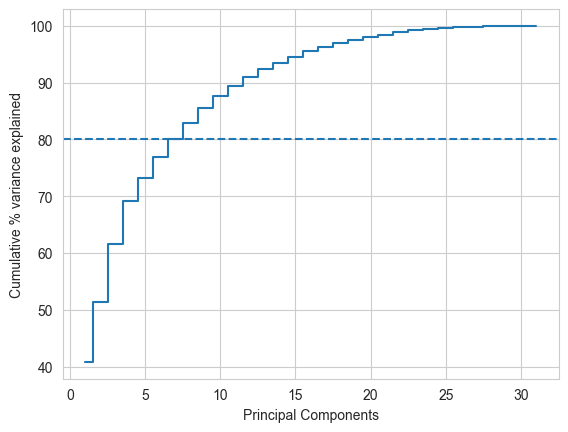

In [113]:
# 1️⃣ Fit PCA on the pre-processed data
X_prepared = preprocessor.fit_transform(df_km)
pca = PCA().fit(X_prepared)

# 2️⃣ Plot cumulative explained variance
plt.step(range(1, len(pca.explained_variance_ratio_)+1),
         np.cumsum(pca.explained_variance_ratio_)*100, where='mid')
plt.xlabel("Principal Components")
plt.ylabel("Cumulative % variance explained")
plt.axhline(80, ls='--')
plt.show()


In [67]:
loadings = pd.DataFrame(
    pca.components_.T,
    index = preprocessor.get_feature_names_out(),
    columns = [f'PC{i+1}' for i in range(pca.n_components_)]
)

# Show top ±5 strongest contributors for the first few PCs
for pc in loadings.columns[:5]:
    print(f"\n=== {pc} ===")
    print(loadings[pc].abs().sort_values(ascending=False).head(5))



=== PC1 ===
num__SHOP_ONLINE    0.295751
num__DINK           0.290256
num__OWN_HOUSE      0.284821
num__SOCCL_A        0.280141
num__EDU_LOW        0.276587
Name: PC1, dtype: float64

=== PC2 ===
num__EDU_MID     0.515620
num__SOCCL_B2    0.435204
num__SOCCL_A     0.353095
num__SOCCL_B1    0.344760
num__EDU_HIGH    0.342230
Name: PC2, dtype: float64

=== PC3 ===
num__STAGE_OF_LIFE    0.400677
num__CIT_HOUSEHOLD    0.378283
num__URB              0.377165
num__EDU_LOW          0.346691
num__CAR              0.337167
Name: PC3, dtype: float64

=== PC4 ===
num__LOAN             0.566232
num__URB              0.421346
num__CIT_HOUSEHOLD    0.420168
num__EDU_MID          0.347893
num__SOCCL_B2         0.205440
Name: PC4, dtype: float64

=== PC5 ===
num__SOCCL_B2        0.526832
num__INCOME_final    0.447461
num__URB             0.426732
num__SOCCL_B1        0.276384
num__SOCCL_D         0.270220
Name: PC5, dtype: float64


In [68]:
loadings = pd.DataFrame(
    pca.components_.T,
    index=preprocessor.get_feature_names_out(),
    columns=[f'PC{i+1}' for i in range(pca.n_components_)]
)

loadings = loadings.reset_index().rename(columns={'index':'feature'})

In [69]:
loadings.head(10)

feature       PC1       PC2       PC3       PC4       PC5  \
0           num__URB  0.099479 -0.000287  0.377165 -0.421346  0.426732   
1  num__INCOME_final -0.198418  0.036471  0.185783 -0.121074 -0.447461   
2       num__SOCCL_A  0.280141 -0.353095 -0.091026  0.070861  0.033330   
3      num__SOCCL_B1  0.223980  0.344760  0.004993 -0.189046 -0.276384   
4      num__SOCCL_B2 -0.115921  0.435204  0.087230  0.205440  0.526832   
5       num__SOCCL_C -0.269847 -0.029202 -0.060577 -0.029771  0.017727   
6       num__SOCCL_D -0.261107 -0.186341  0.141655 -0.096108 -0.270220   
7      num__EDU_HIGH  0.260848 -0.342230 -0.189639  0.097091  0.122213   
8       num__EDU_MID  0.076141  0.515620 -0.169642 -0.347893 -0.195223   
9       num__EDU_LOW -0.276587 -0.027864  0.346691  0.125838  0.073299   

        PC6       PC7       PC8       PC9  ...      PC22      PC23      PC24  \
0 -0.150401 -0.432181  0.086400  0.150384  ... -0.075629 -0.028821 -0.051252   
1  0.507993 -0.338257  0.010912  0.515412  ...  0.036874 -0.016939 -0.000912   
2  0.015945  0.005727  0.018633  0.081570  ...  0.662401 -0.318621 -0.116026   
3 -0.035603  0.010990 -0.331115 -0.017551  ...  0.157732 -0.129626 -0.138428   
4  0.422641 -0.026754 -0.062909 -0.126151  ...  0.110966 -0.101050 -0.110923   
5 -0.236319  0.080534  0.706791  0.218396  ...  0.053325 -0.069694 -0.068861   
6 -0.275161 -0.185838 -0.291854 -0.180255  ...  0.042405 -0.060082 -0.098602   
7  0.075559 -0.091555 -0.107569  0.150587  ... -0.046354  0.009311  0.375897   
8 -0.067353  0.132696  0.211438 -0.094661  ...  0.242805 -0.074483  0.342047   
9 -0.046506 -0.049744 -0.075019 -0.079872  ...  0.416328 -0.121856  0.459875   

       PC25      PC26      PC27      PC28      PC29      PC30          PC31  
0 -0.045017 -0.024930 -0.001403  0.015520 -0.002511 -0.006195  0.000000e+00  
1 -0.006229 -0.011792 -0.004735 -0.000853 -0.005178 -0.008789 -3.864057e-16  
2  0.295235 -0.017115  0.008182  0.055878 -0.022178 -0.015737  8.348590e-16  
3  0.147274 -0.016877 -0.005244  0.013122  0.006377  0.001076 -2.381482e-16  
4  0.120223 -0.019724  0.000746  0.020735 -0.005647  0.000652 -4.142921e-16  
5  0.109895  0.005277  0.003663  0.024233 -0.000760  0.006396 -5.358852e-16  
6  0.067577  0.026870 -0.003301  0.024256  0.005425  0.009692 -2.988176e-16  
7 -0.418088 -0.014835 -0.008523 -0.045642  0.019753  0.020011 -1.210881e-15  
8 -0.249844  0.012972  0.007376 -0.001804  0.002161  0.011700  5.304172e-16  
9 -0.317062  0.018535 -0.019785 -0.020098 -0.006131  0.005695  2.882029e-16  

[10 rows x 32 columns]

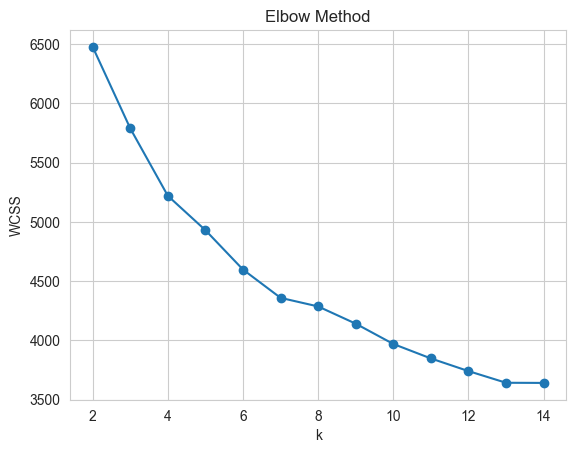

In [70]:
wcss = []                         # within-cluster sum of squares
K = range(2, 15)
for k in K:
    km = KMeans(n_clusters=k, random_state=1)
    km.fit(X_prepared)
    wcss.append(km.inertia_)

plt.plot(K, wcss, marker='o')
plt.xlabel('k')
plt.ylabel('WCSS')
plt.title('Elbow Method')
plt.show()

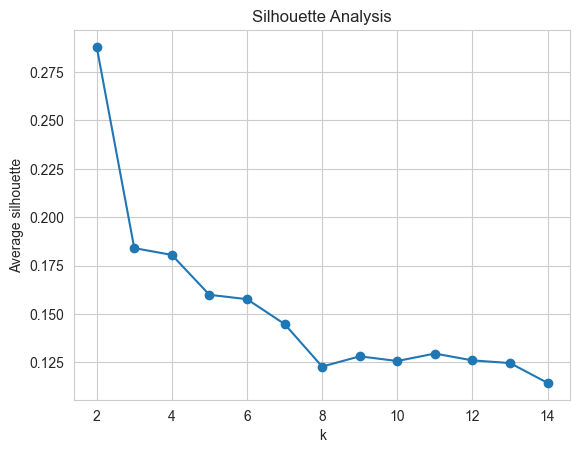

In [71]:
sil = []
for k in K:
    km = KMeans(n_clusters=k, random_state=1)
    labels = km.fit_predict(X_prepared)
    sil.append(silhouette_score(X_prepared, labels))

plt.plot(K, sil, marker='o')
plt.xlabel('k')
plt.ylabel('Average silhouette')
plt.title('Silhouette Analysis')
plt.show()


In [139]:
k_final = 8
n_pcs   = 10           # or whatever your elbow-cum-variance plot suggested

pipeline = Pipeline([
    ('prep', preprocessor),
    ('pca',  PCA(n_components=n_pcs, random_state=1)),   # comment out if you skip PCA
    ('km',   KMeans(n_clusters=k_final, random_state=1))
])

df_km['cluster'] = pipeline.fit_predict(df_km)

In [140]:
sizes = df_km['cluster'].value_counts().sort_index()
print(sizes)

cluster
0    72
1    87
2    56
3    27
4    86
5    42
6    66
7    51
Name: count, dtype: int64


In [141]:
centroids_pca = pipeline.named_steps['km'].cluster_centers_
centroids_pca = pd.DataFrame(centroids_pca,
                             columns=[f'PC{i+1}' for i in range(centroids_pca.shape[1])])

In [142]:
pcs = pipeline.named_steps['pca'].transform(preprocessor.transform(df_km))

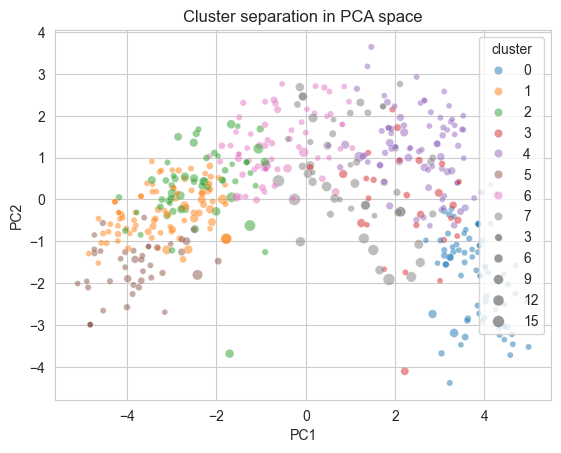

In [143]:
sns.scatterplot(x=pcs[:,0], 
                y=pcs[:,1], 
                hue=df_km['cluster'], 
                size=pcs[:,2]**2,
                palette='tab10', 
                alpha=.5)
plt.xlabel('PC1'); plt.ylabel('PC2')
plt.title('Cluster separation in PCA space')
plt.show()

In [144]:
# Assume pcs is shape (n_samples, n_components)
pcs_df = pd.DataFrame(pcs, columns=[f'PC{i+1}' for i in range(pcs.shape[1])])
pcs_df['cluster'] = df_km['cluster'].values

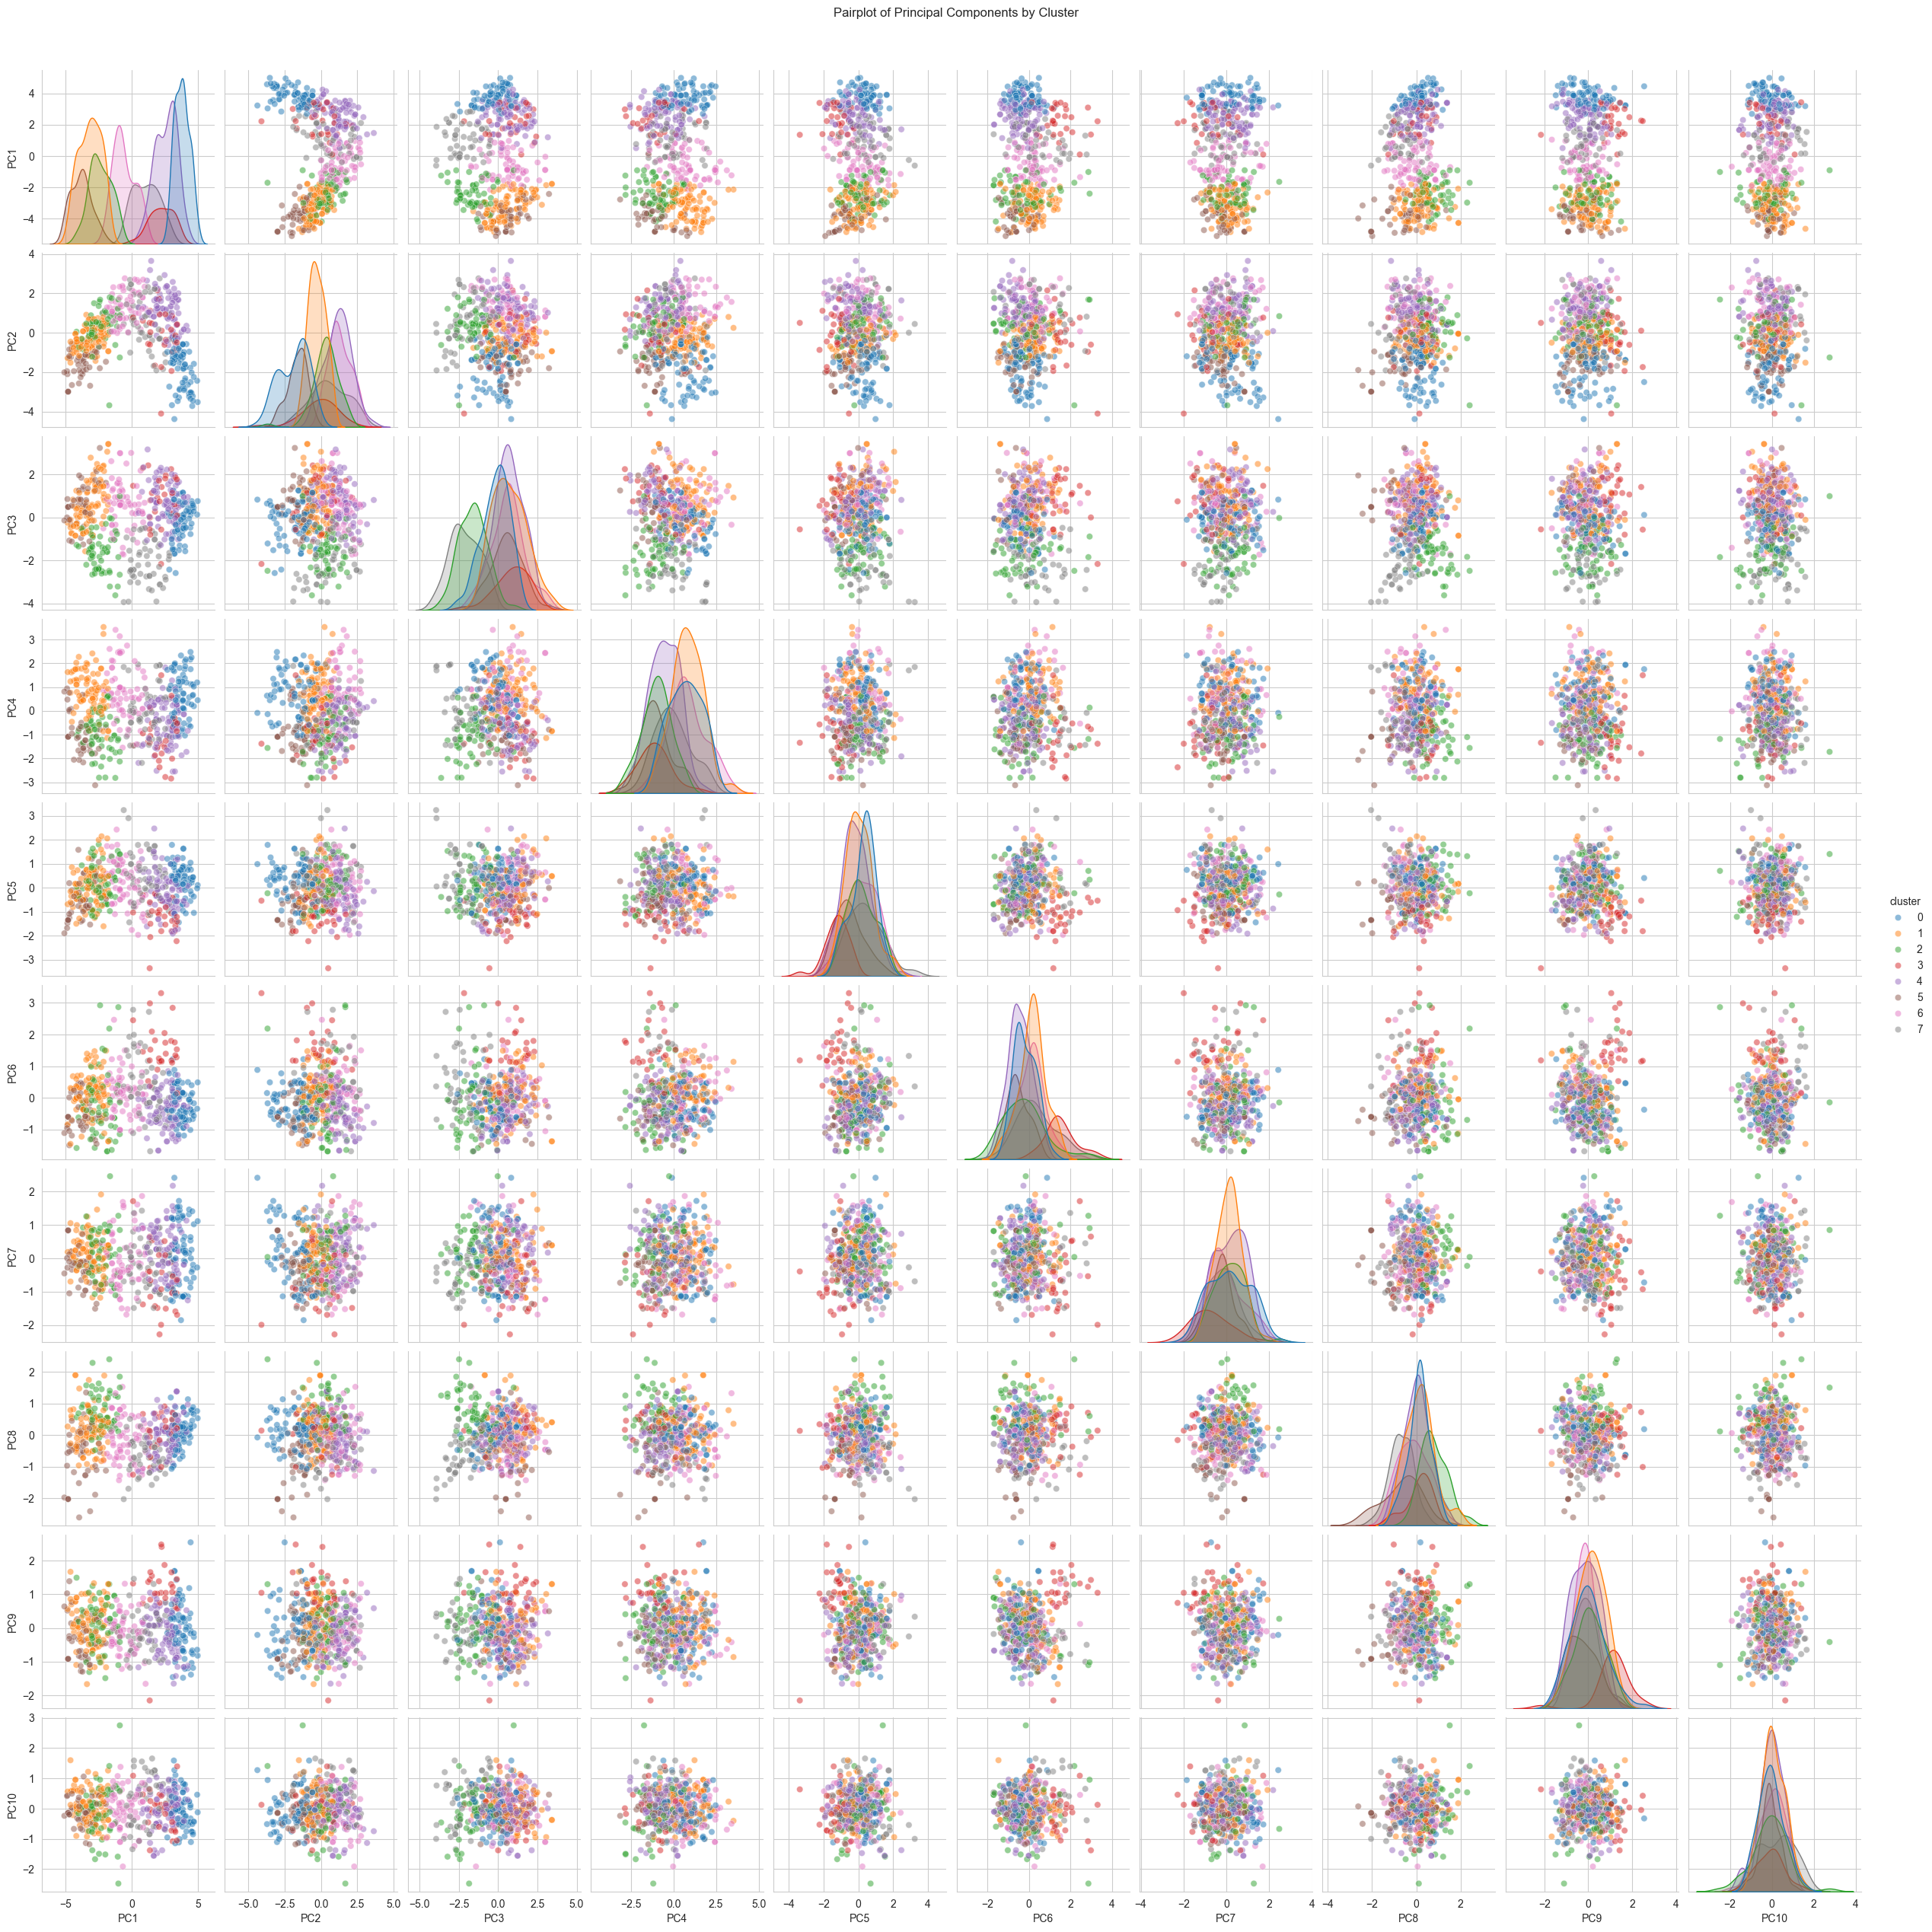

In [145]:
sns.pairplot(
    pcs_df, 
    vars=[f'PC{i+1}' for i in range(pcs.shape[1])],  # e.g., ['PC1', 'PC2', 'PC3', ...]
    hue='cluster', 
    palette='tab10', 
    plot_kws={'alpha': 0.5}
)
plt.suptitle('Pairplot of Principal Components by Cluster', y=1.02)
plt.show()


In [146]:
# Example: Identify types (you can adjust if you have more info)
categorical_cols = ['PROVINCE',"cluster"]
numerical_cols = [col for col in df_km.columns if col not in categorical_cols]

In [147]:
# Aggregation dict
agg_dict = {}
for col in df_km.columns:
    if col in categorical_cols:
        agg_dict[col] = lambda x: x.mode()[0] if not x.mode().empty else None
    else:
        agg_dict[col] = 'mean'

In [148]:
# By cluster
pivot_by_cluster = df_km.groupby('cluster').agg(agg_dict)

In [149]:
print(pivot_by_cluster)

              PROVINCE       URB  INCOME_final   SOCCL_A  SOCCL_B1  SOCCL_B2  \
cluster                                                                        
0           Gelderland  3.527778      1.652778  4.458333  2.097222  1.555556   
1        South Holland  2.563218      4.103448  1.022989  1.206897  3.114943   
2        South Holland  2.696429      3.357143  1.125000  1.482143  2.660714   
3        South Holland  4.777778      5.851852  2.962963  3.148148  2.037037   
4        South Holland  4.500000      2.395349  2.127907  3.558140  2.511628   
5        South Holland  3.547619      4.190476  1.071429  1.261905  1.785714   
6        South Holland  3.015152      3.287879  1.136364  2.378788  3.696970   
7        South Holland  2.333333      2.431373  2.352941  3.039216  2.941176   

          SOCCL_C   SOCCL_D  EDU_HIGH   EDU_MID  ...      DINK  OWN_HOUSE  \
cluster                                          ...                        
0        1.083333  1.013889  4.569444  2.1111

In [150]:
df_km.to_csv("customers_with_clusters.csv", index=False)

In [151]:
# 1. grab fitted steps
scaler = pipeline.named_steps['prep'] \
                .named_transformers_['num'] \
                .named_steps['scaler']
ohe    = pipeline.named_steps['prep'] \
                .named_transformers_['cat'] \
                .named_steps['ohe']
pca    = pipeline.named_steps['pca']
km     = pipeline.named_steps['km']

# 2. get cluster centers in PCA space
centroids_pca = km.cluster_centers_

# 3. inverse‐PCA → back to scaled & one-hot space
centroids_preproc = pca.inverse_transform(centroids_pca)

# 4. split numeric vs encoded parts
n_num = len(num_features)
num_scaled = centroids_preproc[:, :n_num]
cat_encoded = centroids_preproc[:, n_num:]

# 5. inverse‐scale numerics → original units
num_orig = scaler.inverse_transform(num_scaled)

# 6. inverse‐encode categoricals → original PROVINCE values
#    Note: result is shape (n_clusters, 1)
province_orig = ohe.inverse_transform(cat_encoded).ravel()

# 7. assemble into a DataFrame
centroids_df = pd.DataFrame(num_orig, columns=num_features)
centroids_df['PROVINCE'] = province_orig

# 8. round for readability
centroids_df[num_features] = centroids_df[num_features].round(2)

print("Cluster centers back in original feature space:")
print(centroids_df)


Cluster centers back in original feature space:
    URB  INCOME_final  SOCCL_A  SOCCL_B1  SOCCL_B2  SOCCL_C  SOCCL_D  \
0  3.49          1.65     4.37      2.18      1.55     1.13     0.97   
1  2.54          4.10     0.98      1.17      3.12     2.92     2.51   
2  2.68          3.34     1.12      1.61      2.65     3.38     1.95   
3  4.71          5.73     2.77      3.17      2.03     1.22     1.28   
4  4.52          2.44     2.23      3.48      2.53     1.31     1.19   
5  3.54          4.22     1.12      1.28      1.81     2.62     3.84   
6  3.11          3.29     1.19      2.39      3.67     1.87     1.67   
7  2.33          2.42     2.38      2.93      2.93     1.21     1.07   

   EDU_HIGH  EDU_MID  EDU_LOW  DINK  OWN_HOUSE  AVG_HOUSE  STAGE_OF_LIFE  \
0      4.58     1.99     1.39  4.97       4.18       9.64           6.24   
1      1.19     2.13     4.66  2.13       1.41       4.45           3.86   
2      1.43     4.02     2.71  1.73       1.62       3.71           1.98   

In [152]:
centroids_df

URB  INCOME_final  SOCCL_A  SOCCL_B1  SOCCL_B2  SOCCL_C  SOCCL_D  \
0  3.49          1.65     4.37      2.18      1.55     1.13     0.97   
1  2.54          4.10     0.98      1.17      3.12     2.92     2.51   
2  2.68          3.34     1.12      1.61      2.65     3.38     1.95   
3  4.71          5.73     2.77      3.17      2.03     1.22     1.28   
4  4.52          2.44     2.23      3.48      2.53     1.31     1.19   
5  3.54          4.22     1.12      1.28      1.81     2.62     3.84   
6  3.11          3.29     1.19      2.39      3.67     1.87     1.67   
7  2.33          2.42     2.38      2.93      2.93     1.21     1.07   

   EDU_HIGH  EDU_MID  EDU_LOW  DINK  OWN_HOUSE  AVG_HOUSE  STAGE_OF_LIFE  \
0      4.58     1.99     1.39  4.97       4.18       9.64           6.24   
1      1.19     2.13     4.66  2.13       1.41       4.45           3.86   
2      1.43     4.02     2.71  1.73       1.62       3.71           1.98   
3      2.98     3.45     1.82  4.42       3.69       9.76           6.51   
4      2.22     4.30     2.00  4.96       4.22       7.22           6.60   
5      1.32     1.97     4.72  1.38       1.51       2.85           2.50   
6      1.44     3.27     3.56  3.65       2.50       5.46           4.55   
7      3.11     3.68     1.40  3.20       2.39       6.60           2.03   

   CIT_HOUSEHOLD  LOAN  SAVINGS  SHOP_ONLINE   CAR       PROVINCE  
0           4.65  2.99     5.59         5.82  4.62  South Holland  
1           4.09  3.75     2.49         2.18  2.53  South Holland  
2           2.55  3.09     4.25         3.29  1.57  South Holland  
3           4.23  2.42     5.48         5.09  4.29     Overijssel  
4           4.54  3.08     5.02         5.47  4.96  South Holland  
5           3.05  2.12     2.44         1.60  2.02  South Holland  
6           4.53  4.14     3.64         4.09  3.66  South Holland  
7           2.91  3.89     5.30         5.44  2.96  South Holland

In [153]:
############# ANOTHER FORMAT

In [154]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# 1. Preprocessing
X = df_sub.select_dtypes(include='number')  # only numerics for clustering
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 2. Clustering on original
kmeans_orig = KMeans(n_clusters=3, random_state=42).fit(X_scaled)
labels_orig = kmeans_orig.labels_
print('Silhouette score (orig):', silhouette_score(X_scaled, labels_orig))

# 3. PCA
pca = PCA(n_components=0.9)  # enough components for 90% variance
X_pca = pca.fit_transform(X_scaled)
print('PCA components:', X_pca.shape[1])

# 4. Clustering on PCA
kmeans_pca = KMeans(n_clusters=3, random_state=42).fit(X_pca)
labels_pca = kmeans_pca.labels_
print('Silhouette score (PCA):', silhouette_score(X_pca, labels_pca))


Silhouette score (orig): 0.22529573651749776
PCA components: 10
Silhouette score (PCA): 0.25088282497513226


In [ ]:
###

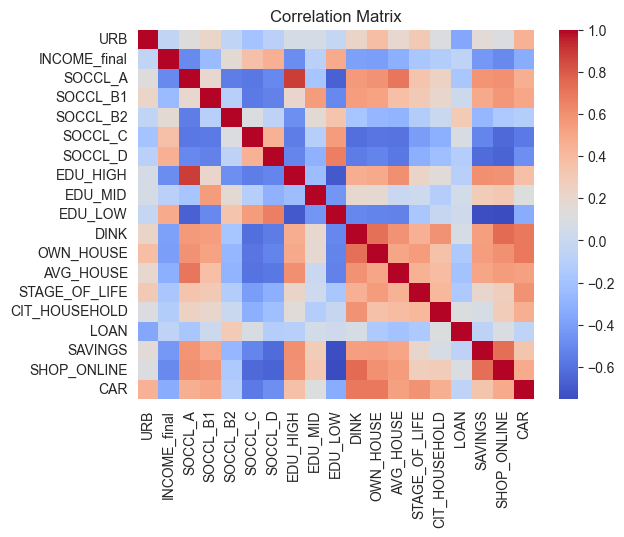

In [155]:
numeric_cols = df_sub.select_dtypes(include='number').columns
corr = df_sub[numeric_cols].corr()
sns.heatmap(corr, annot=False, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

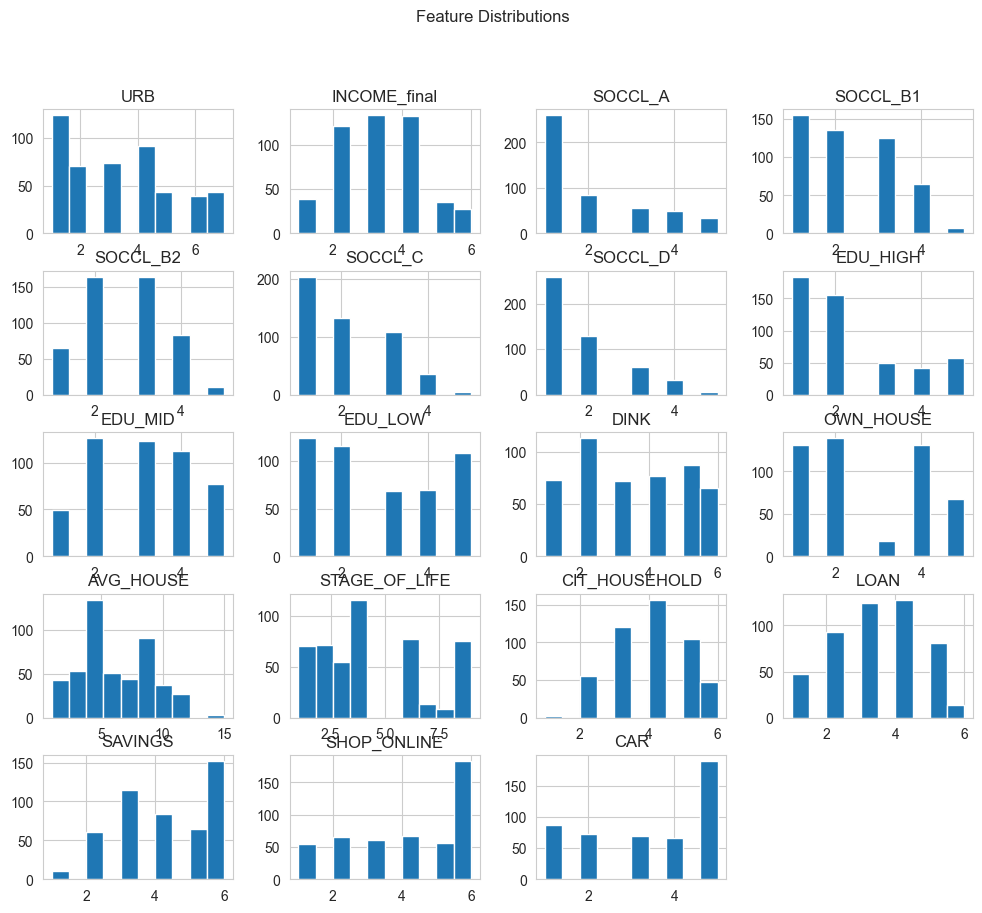

In [156]:
df_sub[numeric_cols].hist(figsize=(12, 10))
plt.suptitle('Feature Distributions')
plt.show()

In [157]:
df_sub_clean = df_sub.dropna()  # or use imputation if many missing

In [158]:
categorical_cols = df_sub.select_dtypes(include='object').columns
df_sub_encoded = pd.get_dummies(df_sub_clean, columns=categorical_cols, drop_first=True)

In [159]:
from sklearn.preprocessing import StandardScaler

X = df_sub_encoded.select_dtypes(include='number')
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [160]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

kmeans = KMeans(n_clusters=3, random_state=42)
labels = kmeans.fit_predict(X_scaled)
score = silhouette_score(X_scaled, labels)
print(f'Silhouette score without PCA: {score:.3f}')

Silhouette score without PCA: 0.225


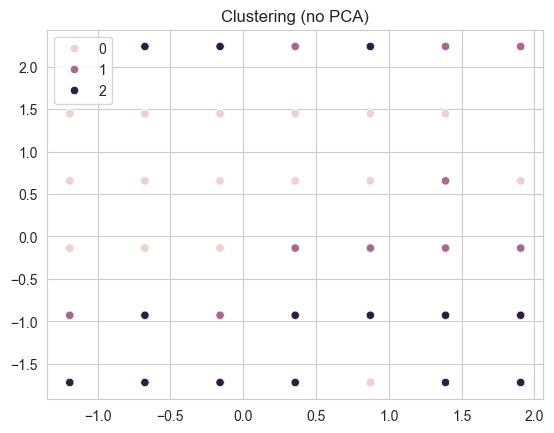

In [161]:
# If you want to see first two features
sns.scatterplot(x=X_scaled[:,0], y=X_scaled[:,1], hue=labels)
plt.title('Clustering (no PCA)')
plt.show()


In [162]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.9)  # keep enough components for 90% variance
X_pca = pca.fit_transform(X_scaled)
print('Number of PCA components:', X_pca.shape[1])

Number of PCA components: 10


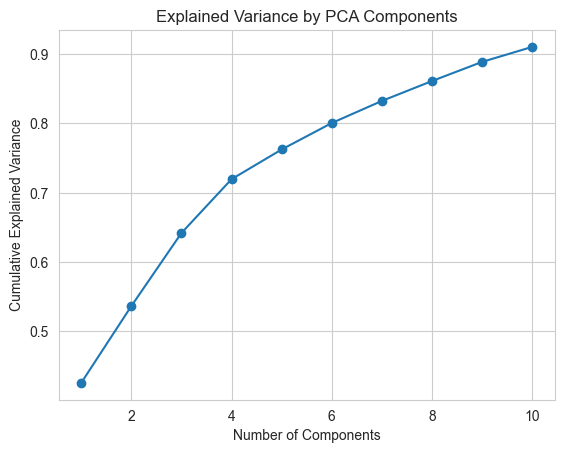

In [163]:
plt.plot(range(1, len(pca.explained_variance_ratio_)+1), pca.explained_variance_ratio_.cumsum(), marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by PCA Components')
plt.show()

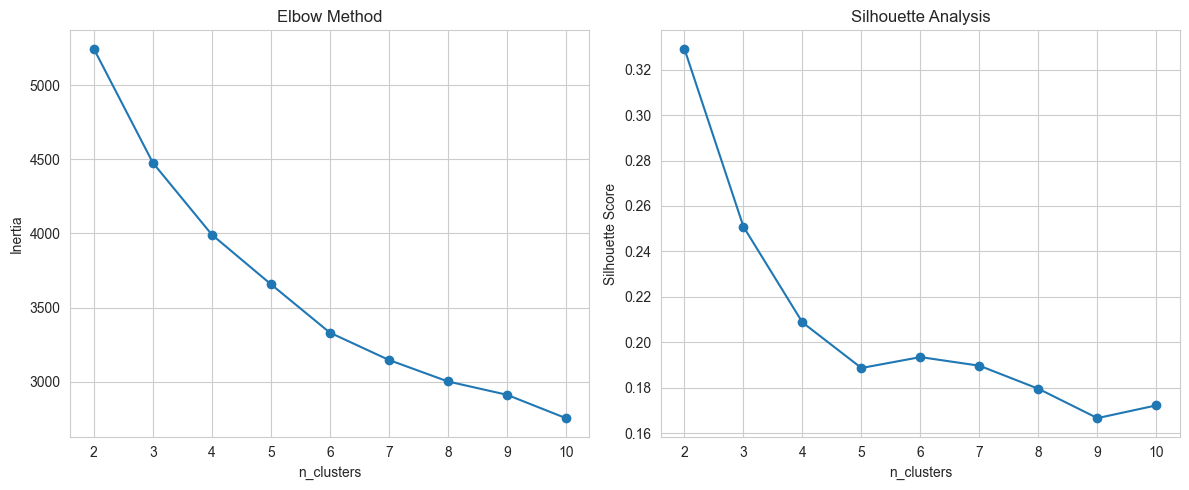

Optimal number of clusters by silhouette: 2


In [173]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

sil_scores = []
inertias = []
K = range(2, 11)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_pca[:, :n_components])  # use reduced data
    sil = silhouette_score(X_pca[:, :n_components], labels)
    sil_scores.append(sil)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(K, inertias, marker='o')
plt.xlabel('n_clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method')

plt.subplot(1,2,2)
plt.plot(K, sil_scores, marker='o')
plt.xlabel('n_clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis')
plt.tight_layout()
plt.show()

# Optionally, print best k by silhouette
best_k = K[np.argmax(sil_scores)]
print(f"Optimal number of clusters by silhouette: {best_k}")


In [179]:
sil_matrix = np.zeros((10, 10))  # 10 components x 10 clusters example

for nc in range(2, 11):
    pca = PCA(n_components=nc)
    X_pc = pca.fit_transform(X_scaled)
    for k in range(2, 11):
        kmeans = KMeans(n_clusters=k, random_state=42)
        labels = kmeans.fit_predict(X_pc)
        sil = silhouette_score(X_pc, labels)
        sil_matrix[nc-1, k-1] = sil

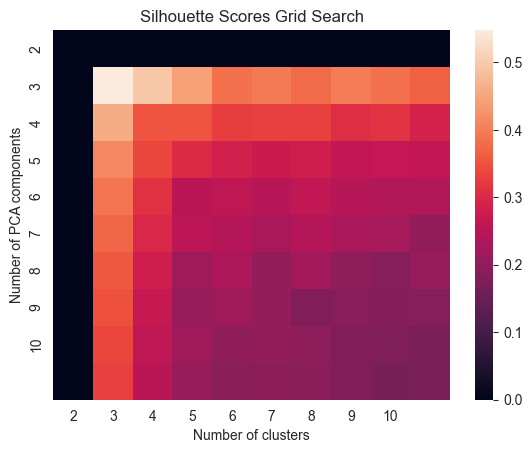

In [180]:
sns.heatmap(sil_matrix, xticklabels=range(2,11), yticklabels=range(2,11))
plt.xlabel('Number of clusters')
plt.ylabel('Number of PCA components')
plt.title('Silhouette Scores Grid Search')
plt.show()

In [181]:
kmeans_pca = KMeans(n_clusters=3, random_state=42)
labels_pca = kmeans_pca.fit_predict(X_pca)
score_pca = silhouette_score(X_pca, labels_pca)
print(f'Silhouette score with PCA: {score_pca:.3f}')

Silhouette score with PCA: 0.251


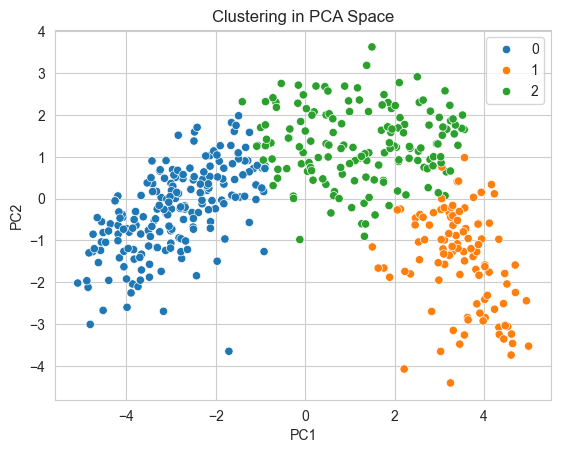

In [182]:
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=labels_pca, palette='tab10')
plt.xlabel('PC1'); plt.ylabel('PC2')
plt.title('Clustering in PCA Space')
plt.show()

In [186]:
# Adjust the range if you used a different number of components
pc_columns = [f'PC{i+1}' for i in range(X_pca.shape[1])]

df_pca = pd.DataFrame(X_pca, columns=pc_columns)
df_pca['cluster'] = labels_pca.astype(str)  # Convert to string for color-coding

In [187]:
df_pca

PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0    3.297262 -1.260339  0.994777 -1.054692  0.680869 -0.118394 -0.699202   
1    4.694218 -1.586659  0.436484  0.195923 -1.033886 -0.169516  1.138653   
2    3.127039  0.070136  0.255749 -2.641586 -0.693923 -0.219246  1.965835   
3    3.250764  1.861623  0.169809  0.297169 -1.268526 -0.895305  0.577560   
4   -3.007164 -0.768839  0.571694  0.701799  0.113798  0.555735  1.036329   
..        ...       ...       ...       ...       ...       ...       ...   
482  0.882001  2.688729 -0.166456  1.618697 -1.110378 -0.644854 -0.486254   
483 -4.715942 -1.196000 -0.108813  0.722622 -1.088678 -1.023744 -0.199037   
484  1.332085  1.072283  0.076600  0.171739  0.463040  0.331351  0.597496   
485  3.935723  0.150626  0.913897 -0.141321 -0.545047 -0.262531 -0.044035   
486  1.256299  1.010881  1.734020 -1.113577  0.591082 -0.737704 -0.671908   

          PC8       PC9      PC10 cluster  
0    0.947801 -1.007773  0.987011       1  
1    0.057249 -0.297285 -0.477973       1  
2   -0.568349 -0.199318  0.620543       2  
3   -0.248299 -0.498141  0.117954       2  
4    0.225359  0.132158 -0.105264       0  
..        ...       ...       ...     ...  
482  0.411112  0.840102 -0.701181       2  
483 -0.491824 -0.291148 -0.215374       0  
484 -0.476011 -0.230069  1.020550       2  
485  0.605827 -1.251238 -0.385689       1  
486 -0.601203  0.136633 -0.192087       2  

[487 rows x 11 columns]

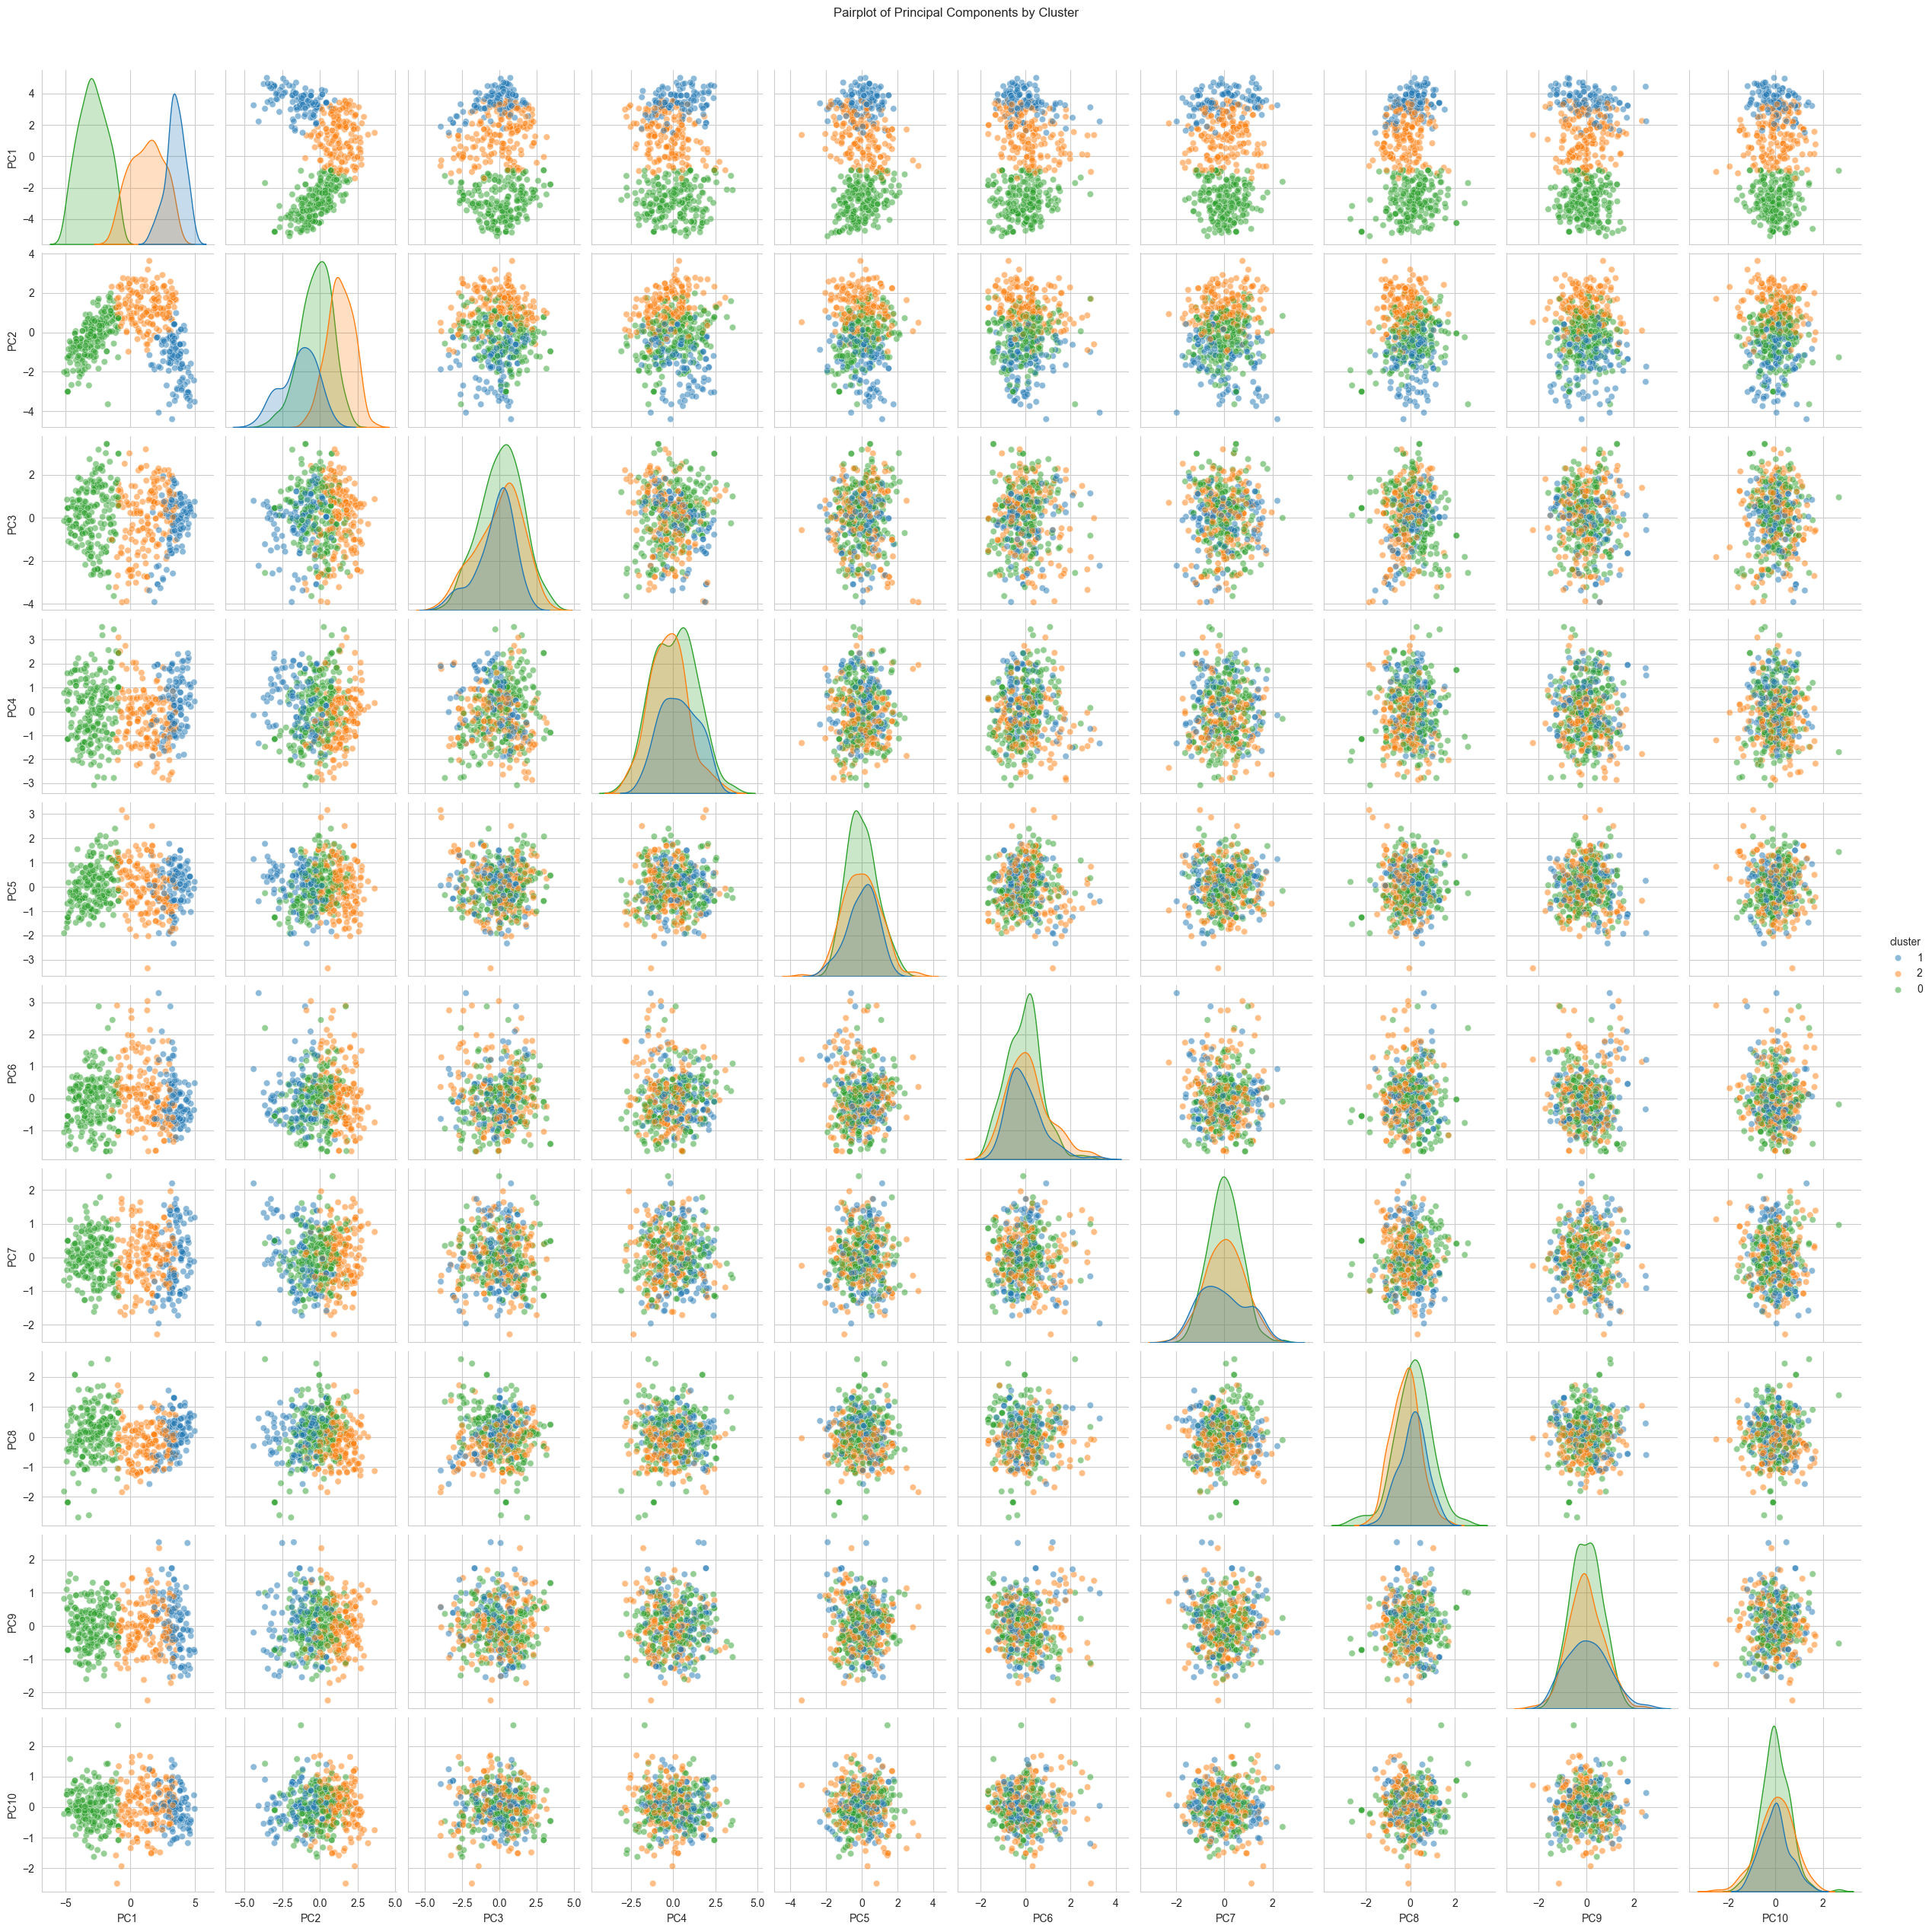

In [188]:
sns.pairplot(
    df_pca, 
    vars=pc_columns,         # All PC columns
    hue='cluster',           # Color by cluster
    palette='tab10',         # Nice color scheme
    plot_kws={'alpha': 0.5}  # Transparency for overlap
)
plt.suptitle('Pairplot of Principal Components by Cluster', y=1.02)
plt.show()

In [166]:
df_sub_encoded['cluster_noPCA'] = labels
df_sub_encoded['cluster_PCA'] = labels_pca

In [167]:
# For numerical
num_summary = df_sub_encoded.groupby('cluster_PCA')[X.columns].mean()
print(num_summary)

# For categoricals
for col in categorical_cols:
    print(df_sub.groupby(df_sub_encoded['cluster_PCA'])[col].value_counts(normalize=True))

                  URB  INCOME_final   SOCCL_A  SOCCL_B1  SOCCL_B2   SOCCL_C  \
cluster_PCA                                                                   
0            2.861905      3.847619  1.061905  1.385714  2.814286  2.866667   
1            3.699115      2.194690  4.053097  2.433628  1.654867  1.132743   
2            3.609756      2.981707  1.798780  3.225610  3.012195  1.439024   

              SOCCL_D  EDU_HIGH   EDU_MID   EDU_LOW      DINK  OWN_HOUSE  \
cluster_PCA                                                                
0            2.571429  1.323810  2.642857  4.119048  2.042857   1.566667   
1            1.026549  4.247788  2.477876  1.336283  4.858407   4.035398   
2            1.243902  2.048780  4.073171  2.237805  4.085366   3.304878   

             AVG_HOUSE  STAGE_OF_LIFE  CIT_HOUSEHOLD      LOAN   SAVINGS  \
cluster_PCA                                                                
0             4.023810       3.161905       3.576190  3.347619  3.01428